### Training RNN using World's data

This is based on `COVID-19 growth prediction using multivariate
long short term memory` by `Novanto Yudistira`

https://arxiv.org/pdf/2005.04809.pdf

https://github.com/VICS-CORE/lstmcorona/blob/master/lstm.py

- We've aligned all countries' inputs rather than taking an absolute timeline. We start when cumulative number of confirmed cases in the country has crossed 100.
- We've normalised data by dividing by a population factor. That way the network can learn a general understanding of the pattern irrespective of the country's population.
- Rather than using the entire timeline as an input as suggested by NYudistira, we're training a fixed window (e.g. 20 days) so that the model learns to predict the future by looking at present data. The problem with fixed window approach is that some countries have peaked, while others have not. Also few countries start early, and some start late.
- The paper uses a multivariate network with confirmed, recovered and deceased data. However this'd increase computation time and hence we're restricting ourselves to a univariate model with confirmed cases as the only parameter.

#### Other ideas
- One idea is to train the current net with only the most populous countries' data, since their behaviour would be similar to India's.
- Adding metrics like humidity, population density, lockdown intensity etc might be beneficial and should have some correlation with the growth in cases. But this'd need more computation power.
- Another idea is to train a neuralnet to predict SIR like buckets.

In [149]:
import pandas as pd
import numpy as np
import requests as rq
import datetime as dt
import torch

tnn = torch.nn
top = torch.optim
from torch.utils import data as tdt

from matplotlib.ticker import MultipleLocator
from matplotlib.dates import DayLocator, AutoDateLocator, ConciseDateFormatter

In [2]:
CUDA="cuda:0"
CPU="cpu"
device = torch.device(CUDA if torch.cuda.is_available() else CPU)
print(device)

cpu


In [3]:
# define paths
DATA_DIR = 'data'
MODELS_DIR = 'models'

### Colab only

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd 'drive/My Drive/CS/colab/'

### Read OWID data

In [99]:
!curl https://covid.ourworldindata.org/data/owid-covid-data.csv --output data/owid-covid-data.csv

In [4]:
!head -n1 data/owid-covid-data.csv

iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k


In [100]:
cols = ['location', 'date', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'population']
dates = ['date']
df = pd.read_csv(DATA_DIR + "/owid-covid-data.csv", 
                 usecols=cols,
                 parse_dates=dates)
df.sample()

,location,date,total_cases,new_cases,total_deaths,new_deaths,population
14211,Mauritania,2020-06-04,668,0,31,0,4649660.0


### LSTM

In [6]:
class YudistirNet(tnn.Module):
    def __init__(self, ip_seq_len=1, op_seq_len=1, hidden_size=1, num_layers=1):
        super(YudistirNet, self).__init__()
        
        self.ip_seq_len = ip_seq_len
        self.op_seq_len = op_seq_len
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = tnn.LSTM(input_size=1, hidden_size=self.hidden_size, num_layers=self.num_layers)
        self.linear = tnn.Linear(self.hidden_size * self.ip_seq_len, self.op_seq_len)
        self.sigmoid = tnn.Sigmoid()
    
    def forward(self, ip):
        lstm_out, _ = self.lstm(ip)
        linear_out = self.linear(lstm_out.view(self.hidden_size * self.ip_seq_len))
        sigmoid_out = self.sigmoid(linear_out.view(self.op_seq_len))
        return sigmoid_out
    
    def predict(self, ip):
        with torch.no_grad():
            preds = self.forward(ip)
        return preds

### Checkpoint methods

In [7]:
def save_checkpoint(epoch, model, optimizer, trn_losses, val_losses, min_val_loss, path=""):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'trn_losses': trn_losses,
        'val_losses': val_losses,
        'min_val_loss': min_val_loss
    }, path or MODELS_DIR + "/latest.pt")
    print("Checkpoint saved")
    
def load_checkpoint(path="", device="cpu"):
    cp = torch.load(path or MODELS_DIR + "/latest.pt", map_location=device)
    print("Checkpoint loaded")
    return cp['epoch'], cp['model_state_dict'], cp['optimizer_state_dict'], cp['trn_losses'], cp['val_losses'], cp.get('min_val_loss', np.Inf)

### Config

In [312]:
# config
IP_SEQ_LEN = 40
OP_SEQ_LEN = 20
VAL_RATIO = 0.3

HIDDEN_SIZE = 20
NUM_LAYERS = 4
LEARNING_RATE = 0.001
NUM_EPOCHS = 3001

# to continue training on another model, set resume to true
RESUME = True

model = YudistirNet(ip_seq_len=IP_SEQ_LEN, op_seq_len=OP_SEQ_LEN, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)
model = model.to(device)

loss_fn = tnn.MSELoss()
optimizer = top.Adam(model.parameters(), lr=LEARNING_RATE)

In [313]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

27940

### Prepare dataset

In [274]:
def gen_dataset():
    ip_trn = []
    op_trn = []

    countries = df['location'].unique()
    pop_countries = ['China', 'United States', 'Indonesia', 'Pakistan', 'Brazil', 'Bangladesh', 'Russia', 'Mexico']

    c = 0
    for country in countries:
        if country in ['World', 'International', 'India']: # Countries to be skipped
            continue
        country_df = df.loc[df.location == country]
        tot_cases_gt_100 = (country_df['total_cases'] >= 100)
        country_df = country_df.loc[tot_cases_gt_100]

        if len(country_df) >= IP_SEQ_LEN + OP_SEQ_LEN:
            c += 1
            pop = country_df['population'].iloc[0]
            print(c, country, len(country_df), pop)
            daily_cases = np.array(country_df['new_cases'].rolling(7, center=True, min_periods=1).mean() * 1000 / pop, dtype=np.float32)

            for i in range(len(country_df) - IP_SEQ_LEN - OP_SEQ_LEN + 1):
                ip_trn.append(daily_cases[i : i+IP_SEQ_LEN])
                op_trn.append(daily_cases[i+IP_SEQ_LEN : i+IP_SEQ_LEN+OP_SEQ_LEN])

    ip_trn = torch.from_numpy(np.array(ip_trn, dtype=np.float32))
    op_trn = torch.from_numpy(np.array(op_trn, dtype=np.float32))
    dataset = tdt.TensorDataset(ip_trn, op_trn)

    val_len = int(VAL_RATIO * len(dataset))
    trn_len = len(dataset) - val_len
    trn_set, val_set = tdt.random_split(dataset, (trn_len, val_len))
    return trn_set, val_set

try:
    ds = torch.load(DATA_DIR + '/ds.pt')
    trn_set, val_set = ds['trn'], ds['val']
    print("Loaded dataset from ds.pt")
except FileNotFoundError:
    trn_set, val_set = gen_dataset()
    torch.save({'trn': trn_set, 'val': val_set}, DATA_DIR + '/ds.pt')
    print("Saved dataset to ds.pt")
finally:
    print("Training data:", len(trn_set), "Validation data:", len(val_set))

trn_loader = tdt.DataLoader(trn_set, shuffle=True, batch_size=1)
val_loader = tdt.DataLoader(val_set, shuffle=True, batch_size=1)

1 Afghanistan 68 38928341.0
2 Albania 73 2877800.0
3 Andorra 74 77265.0
4 United Arab Emirates 79 9890400.0
5 Argentina 77 45195777.0
6 Armenia 78 2963234.0
7 Australia 87 25499881.0
8 Austria 88 9006400.0
9 Azerbaijan 70 10139175.0
10 Belgium 90 11589616.0
11 Burkina Faso 71 20903278.0
12 Bulgaria 77 6948445.0
13 Bahrain 87 1701583.0
14 Bosnia and Herzegovina 74 3280815.0
15 Belarus 66 9449321.0
16 Bolivia 66 11673029.0
17 Brazil 82 212559409.0
18 Brunei 72 437483.0
19 Canada 85 37742157.0
20 Switzerland 90 8654618.0
21 Chile 80 19116209.0
22 China 138 1439323774.0
23 Cote d'Ivoire 69 26378275.0
24 Cameroon 66 26545864.0
25 Democratic Republic of Congo 64 89561404.0
26 Colombia 78 50882884.0
27 Costa Rica 76 5094114.0
28 Cuba 68 11326616.0
29 Cyprus 73 875899.0
30 Czech Republic 84 10708982.0
31 Germany 96 83783945.0
32 Denmark 87 5792203.0
33 Dominican Republic 75 10847904.0
34 Algeria 76 43851043.0
35 Ecuador 79 17643060.0
36 Egypt 81 102334403.0
37 Spain 94 46754783.0
38 Estonia 82

### Train

In [28]:
trn_loss_vals = []
val_loss_vals = []
e = 0
min_val_loss = np.Inf

if RESUME:
    e, model_dict, optimizer_dict, trn_loss_vals, val_loss_vals, min_val_loss = load_checkpoint(device=device)
    e+=1
    model.load_state_dict(model_dict)
    optimizer.load_state_dict(optimizer_dict)

# TRAIN
print("BEGIN: [", dt.datetime.now(), "]")
while e < NUM_EPOCHS:
    model.train()
    trn_losses = []
    for data in trn_loader:
        ip, op = data
        ip = ip.to(device)
        op = op.to(device)
        optimizer.zero_grad() # set grads to 0
        preds = model(ip.view(IP_SEQ_LEN, 1, 1)) # predict
        loss = loss_fn(preds, op.view(OP_SEQ_LEN)) # calc loss
        loss.backward() # calc and assign grads
        optimizer.step() # update weights
        trn_losses.append(loss) # logging
    avg_trn_loss = torch.stack(trn_losses).mean().item() * 10000
    trn_loss_vals.append(avg_trn_loss)
    
    model.eval()
    with torch.no_grad():
        val_losses = []
        for data in val_loader:
            ip, op = data
            ip = ip.to(device)
            op = op.to(device)
            preds = model(ip.view(IP_SEQ_LEN, 1, 1))
            loss = loss_fn(preds, op.view(OP_SEQ_LEN))
            val_losses.append(loss)
        avg_val_loss = torch.stack(val_losses).mean().item() * 10000
        val_loss_vals.append(avg_val_loss)
    
    if e%10==0:
        print("[", dt.datetime.now(), "] epoch:", f"{e:3}", "avg_val_loss:", f"{avg_val_loss: .5f}", "avg_trn_loss:", f"{avg_trn_loss: .5f}")
        save_checkpoint(e, model, optimizer, trn_loss_vals, val_loss_vals, min_val_loss)
        if avg_val_loss <= min_val_loss:
            min_val_loss = avg_val_loss
            save_checkpoint(e, model, optimizer, trn_loss_vals, val_loss_vals, min_val_loss, MODELS_DIR + "/best.pt")
    e+=1
print("END: [", dt.datetime.now(), "]")

Checkpoint loaded
BEGIN: [ 2020-06-03 22:03:30.481107 ]
[ 2020-06-03 22:04:53.342031 ] epoch: 2010 avg_val_loss:  0.07777 avg_trn_loss:  0.00482
Checkpoint saved
[ 2020-06-03 22:06:12.768403 ] epoch: 2020 avg_val_loss:  0.08838 avg_trn_loss:  0.00832
Checkpoint saved
[ 2020-06-03 22:07:35.752701 ] epoch: 2030 avg_val_loss:  0.08032 avg_trn_loss:  0.00735
Checkpoint saved
[ 2020-06-03 22:09:01.481021 ] epoch: 2040 avg_val_loss:  0.07343 avg_trn_loss:  0.00611
Checkpoint saved
Checkpoint saved
[ 2020-06-03 22:10:20.889216 ] epoch: 2050 avg_val_loss:  0.08574 avg_trn_loss:  0.00604
Checkpoint saved
[ 2020-06-03 22:11:38.386615 ] epoch: 2060 avg_val_loss:  0.08409 avg_trn_loss:  0.01529
Checkpoint saved
[ 2020-06-03 22:12:55.775275 ] epoch: 2070 avg_val_loss:  0.07082 avg_trn_loss:  0.00951
Checkpoint saved
Checkpoint saved
[ 2020-06-03 22:14:12.424915 ] epoch: 2080 avg_val_loss:  0.07756 avg_trn_loss:  0.00769
Checkpoint saved
[ 2020-06-03 22:15:28.747896 ] epoch: 2090 avg_val_loss:  0.07

### Load saved model for evaluation

In [314]:
# model_path = MODELS_DIR + "/IP20_OP10_H10_L4_E2001_LR001.pt"
model_path = "/home/mayank/Downloads/ds4020-e17xx.pt"
e, md, _, trn_loss_vals, val_loss_vals, _ = load_checkpoint(model_path, device=device)
print(e)
model.load_state_dict(md)
model.eval()

Checkpoint loaded
1740


YudistirNet(
  (lstm): LSTM(1, 20, num_layers=4)
  (linear): Linear(in_features=800, out_features=20, bias=True)
  (sigmoid): Sigmoid()
)

### Plot losses

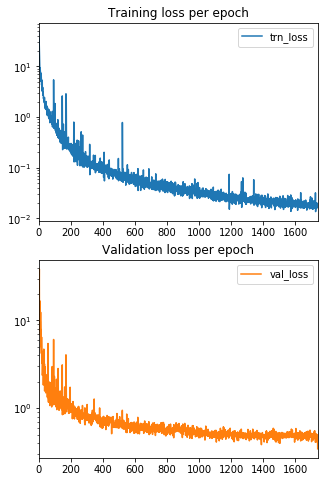

In [315]:
df_trn_loss = pd.DataFrame({
    'trn_loss': trn_loss_vals,
    'val_loss': val_loss_vals
})
_ = df_trn_loss.plot(
    y=['trn_loss', 'val_loss'],
    title=['Training loss per epoch', 'Validation loss per epoch'],
    subplots=True,
    figsize=(5,8),
    sharex=False,
    logy=True
)

### Evalute fit

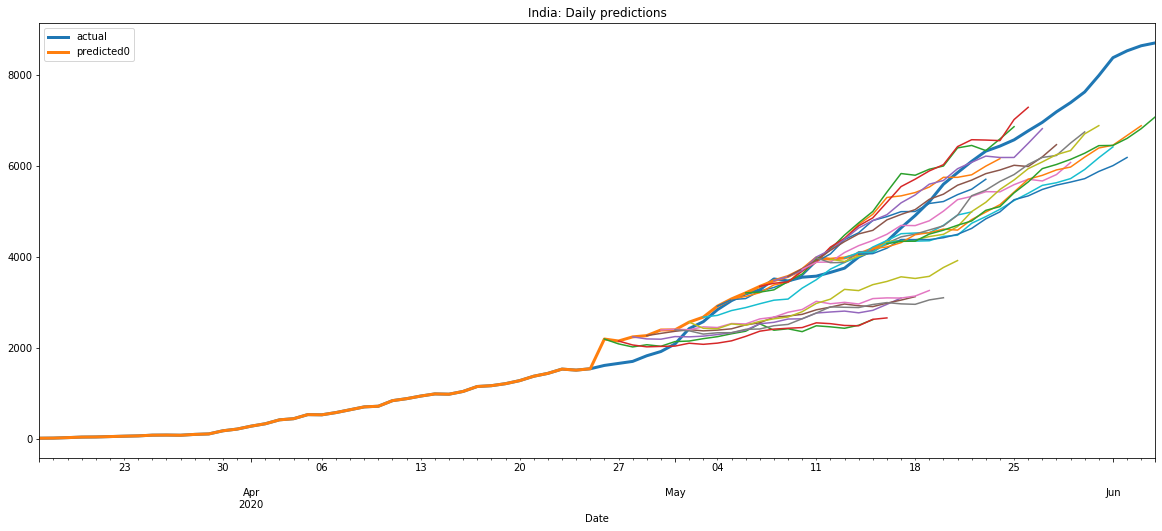

In [316]:
c = "India"
pop_fct = df.loc[df.location==c, 'population'].iloc[0] / 1000

all_preds = []
pred_vals = []
out_vals = []

test_data = np.array(df.loc[(df.location==c) & (df.total_cases>=100), 'new_cases'].rolling(7, center=True, min_periods=1).mean() / pop_fct, dtype=np.float32)

for i in range(len(test_data) - IP_SEQ_LEN - OP_SEQ_LEN + 1):
    ip = torch.tensor(test_data[i : i+IP_SEQ_LEN])
    op = torch.tensor(test_data[i+IP_SEQ_LEN : i+IP_SEQ_LEN+OP_SEQ_LEN])
    ip = ip.to(device)
    op = op.to(device)

    pred = model.predict(ip.view(IP_SEQ_LEN, 1, 1))    
    if i==0: # prepend first input
        pred_vals.extend(ip.view(IP_SEQ_LEN).cpu().numpy() * pop_fct)
        out_vals.extend(ip.view(IP_SEQ_LEN).cpu().numpy() * pop_fct)        
    all_preds.append(pred.view(OP_SEQ_LEN).cpu().numpy() * pop_fct)
    pred_vals.append(pred.view(OP_SEQ_LEN).cpu().numpy()[0] * pop_fct)
    out_vals.append(op.view(OP_SEQ_LEN).cpu().numpy()[0] * pop_fct)

# last N-1 values
out_vals.extend(op.view(OP_SEQ_LEN).cpu().numpy()[1:] * pop_fct)
pred_vals.extend(([np.NaN] * OP_SEQ_LEN)[1:]) # pad with NaN

cmp_df = pd.DataFrame({
    'actual': out_vals,
    'predicted0': pred_vals
})

# plot primary lines
start_date = df.loc[(df.location==c) & (df.total_cases>=100)]['date'].iloc[0]
end_date = start_date + dt.timedelta(days=cmp_df.index[-1])
cmp_df['Date'] = pd.Series([start_date + dt.timedelta(days=i) for i in range(len(cmp_df))])
ax = cmp_df.plot(
    x='Date',
    figsize=(20,8),
    lw=3,
    title=c + ': Daily predictions'
)
mn_l = DayLocator()
ax.xaxis.set_minor_locator(mn_l)
mj_l = AutoDateLocator()
mj_f = ConciseDateFormatter(mj_l, show_offset=False)
ax.xaxis.set_major_formatter(mj_f)

# plot noodles
i=IP_SEQ_LEN
for pred in all_preds:
    cmp_df['predicted_cases'] = np.NaN
    cmp_df.loc[i:i+OP_SEQ_LEN-1, 'predicted_cases'] = pred
    cmp_df.plot(x='Date', y='predicted_cases', ax=ax, legend=False)
    i+=1

### Test (predict) using OWID data

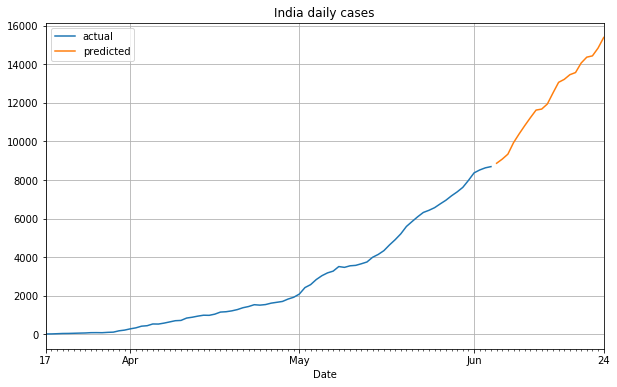

In [324]:
c = "India"
n_days = 20

pop_fct = df.loc[df.location==c, 'population'].iloc[0] / 1000
test_data = np.array(df.loc[(df.location==c) & (df.total_cases>=100), 'new_cases'].rolling(7, center=True, min_periods=1).mean() / pop_fct, dtype=np.float32)

in_data = test_data[-IP_SEQ_LEN:]
out_data = np.array([], dtype=np.float32)
for i in range(int(n_days / OP_SEQ_LEN)):
    ip = torch.tensor(
        in_data,
        dtype=torch.float32
    )
    ip = ip.to(device)
    pred = model.predict(ip.view(IP_SEQ_LEN, 1, 1))
    in_data = np.append(in_data[-IP_SEQ_LEN+OP_SEQ_LEN:], pred.cpu().numpy())
    out_data = np.append(out_data, pred.cpu().numpy())

orig_df = pd.DataFrame({
    'actual': test_data * pop_fct
})
fut_df = pd.DataFrame({
    'predicted': out_data * pop_fct
})
# print(fut_df['predicted'].astype('int').to_csv(sep='|', index=False))
orig_df = orig_df.append(fut_df, ignore_index=True, sort=False)
orig_df['total'] = (orig_df['actual'].fillna(0) + orig_df['predicted'].fillna(0)).cumsum()

start_date = df.loc[(df.location==c) & (df.total_cases>=100)]['date'].iloc[0]
orig_df['Date'] = pd.Series([start_date + dt.timedelta(days=i) for i in range(len(orig_df))])
ax = orig_df.plot(
    x='Date',
    y=['actual', 'predicted'],
    title=c + ' daily cases',
    figsize=(10,6),
    grid=True
)
mn_l = DayLocator()
ax.xaxis.set_minor_locator(mn_l)
mj_l = AutoDateLocator()
mj_f = ConciseDateFormatter(mj_l, show_offset=False)
ax.xaxis.set_major_formatter(mj_f)
# print(orig_df.tail())

# arrow
# peakx = 172
# peak = orig_df.iloc[peakx]
# peak_desc = peak['Date'].strftime("%d-%b") + "\n" + str(int(peak['predicted']))
# _ = ax.annotate(
#     peak_desc, 
#     xy=(peak['Date'] - dt.timedelta(days=1), peak['predicted']),
#     xytext=(peak['Date'] - dt.timedelta(days=45), peak['predicted'] * .9),
#     arrowprops={},
#     bbox={'facecolor':'white'}
# )

# _ = ax.axvline(x=peak['Date'], linewidth=1, color='r')

### Statewise prediction

In [547]:
r=rq.get('https://api.covid19india.org/v3/min/timeseries.min.json')
ts = r.json()

data = []
for state in ts:
    for date in ts[state]:
        data.append((state, date, ts[state][date]['total'].get('confirmed', 0)))

states_df = pd.DataFrame(data, columns=['state', 'date', 'total'])
states_df['date'] = pd.to_datetime(states_df['date'])

In [548]:
# http://www.populationu.com/india-population
STT_INFO = {
    'AN' : {"name": "Andaman & Nicobar Islands", "popn": 450000},
    'AP' : {"name": "Andhra Pradesh", "popn": 54000000},
    'AR' : {"name": "Arunachal Pradesh", "popn": 30000000},
    'AS' : {"name": "Asaam", "popn": 35000000},
    'BR' : {"name": "Bihar", "popn": 123000000},
    'CH' : {"name": "Chandigarh", "popn": 1200000},
    'CT' : {"name": "Chhattisgarh", "popn": 29000000},
    'DL' : {"name": "Delhi", "popn": 19500000},
    'DN' : {"name": "Dadra & Nagar Haveli and Daman & Diu", "popn": 700000},
    'GA' : {"name": "Goa", "popn": 1580000},
    'GJ' : {"name": "Gujarat", "popn": 65000000},
    'HP' : {"name": "Himachal Pradesh", "popn": 7400000},
    'HR' : {"name": "Haryana", "popn": 28000000},
    'JH' : {"name": "Jharkhand", "popn": 38000000},
    'JK' : {"name": "Jammu & Kashmir", "popn": 13600000},
    'KA' : {"name": "Karnataka", "popn": 67000000},
    'KL' : {"name": "Kerala", "popn": 36000000},
    'LA' : {"name": "Ladakh", "popn": 325000},
    'MH' : {"name": "Maharashtra", "popn": 122000000},
    'ML' : {"name": "Meghalaya", "popn": 3400000},
    'MN' : {"name": "Manipur", "popn": 3000000},
    'MP' : {"name": "Madhya Pradesh", "popn": 84000000},
    'MZ' : {"name": "Mizoram", "popn": 1200000},
    'NL' : {"name": "Nagaland", "popn": 2200000},
    'OR' : {"name": "Odisha", "popn": 46000000},
    'PB' : {"name": "Punjab", "popn": 30000000},
    'PY' : {"name": "Puducherry", "popn": 1500000},
    'RJ' : {"name": "Rajasthan", "popn": 80000000},
    'TG' : {"name": "Telangana", "popn": 39000000},
    'TN' : {"name": "Tamil Nadu", "popn": 77000000},
    'TR' : {"name": "Tripura", "popn": 4100000},
    'UP' : {"name": "Uttar Pradesh", "popn": 235000000},
    'UT' : {"name": "Uttarakhand", "popn": 11000000},
    'WB' : {"name": "West Bengal", "popn": 98000000},
#     'SK' : {"name": "Sikkim", "popn": 681000},
#     'UN' : {"name": "Unassigned", "popn": 40000000}, #avg pop
#     'LD' : {"name": "Lakshadweep", "popn": 75000}
}

# uncomment for India
# STT_INFO = {
#     'TT' : {"name": "India", "popn": 1387155000}
# }

#### Dummy state data: fruit country

In [545]:
# dummy data for testing
# SET 1 - 10 states
# STT_INFO = {
#     'A': {"name": "Apple", "popn": 10000000},
#     'B': {"name": "Berry", "popn": 10000000},
#     'C': {"name": "Cherry", "popn": 10000000},
#     'D': {"name": "Dates", "popn": 10000000},
#     'E': {"name": "Elderberry", "popn": 10000000},
#     'F': {"name": "Fig", "popn": 10000000},
#     'G': {"name": "Grape", "popn": 10000000},
#     'H': {"name": "Honeysuckle", "popn": 10000000},
#     'I': {"name": "Icaco", "popn": 10000000},
#     'J': {"name": "Jujube", "popn": 10000000},
# }
# total = 100
# SET 2 - 1 agg state
STT_INFO = {
    'Z': {"name": "FruitCountry1000x", "popn": 10000000},
}
total = 1000


r = {
    'state': [],
    'date': [],
    'total': []
}

start_date = dt.datetime(day=1, month=3, year=2020)
end_date = dt.datetime.now()
while start_date <= end_date:
    for s in STT_INFO:
        r['state'].append(s)
        r['date'].append(start_date)
        r['total'].append(total)
    total *= 1.03
    start_date += dt.timedelta(days=1)
states_df = pd.DataFrame(r)
states_df['date'] = pd.to_datetime(states_df['date'])
states_df.tail()

,state,date,total
98,Z,2020-06-07,18115.403884
99,Z,2020-06-08,18658.866001
100,Z,2020-06-09,19218.631981
101,Z,2020-06-10,19795.190940
102,Z,2020-06-11,20389.046668


In [460]:
def expand(df):
    '''Fill missing dates in an irregular timeline'''
    min_date = df['date'].min()
    max_date = df['date'].max()
    idx = pd.date_range(min_date, max_date)
    
    df.index = pd.DatetimeIndex(df.date)
    df = df.drop(columns=['date'])
    return df.reindex(idx, method='pad').reset_index().rename(columns={'index':'date'})

Andaman & Nicobar Islands | Oct 01 | 69 | 3545
Andhra Pradesh | Sep 20 | 14311 | 697062
Arunachal Pradesh | Nov 08 | 3558 | 228398
Asaam | Aug 09 | 4998 | 272570
Bihar | Oct 01 | 14604 | 821905
Chandigarh | Dec 27 | 53 | 2338
Chhattisgarh | Sep 09 | 3625 | 179202
Delhi | Jun 24 | 2488 | 141890
Dadra & Nagar Haveli and Daman & Diu | Nov 24 | 106 | 4297
Goa | Jun 19 | 70 | 4748
Gujarat | Aug 29 | 9059 | 473340
Himachal Pradesh | Sep 27 | 766 | 58292
Haryana | Aug 04 | 4067 | 195165
Jharkhand | Aug 22 | 5037 | 232344
Jammu & Kashmir | Aug 09 | 2151 | 110561
Karnataka | Nov 18 | 14325 | 579448
Kerala | Oct 01 | 5124 | 236213
Ladakh | Dec 27 | 32 | 3460
Maharashtra | Jul 19 | 16796 | 1541915
Meghalaya | Oct 01 | 497 | 20659
Manipur | Aug 09 | 293 | 30338
Madhya Pradesh | Oct 21 | 8837 | 719312
Mizoram | Aug 02 | 100 | 7121
Nagaland | Oct 07 | 262 | 13674
Odisha | Oct 22 | 5719 | 417555
Punjab | Sep 20 | 5257 | 230506
Puducherry | Aug 22 | 233 | 10117
Rajasthan | Nov 24 | 9412 | 839299
Telan

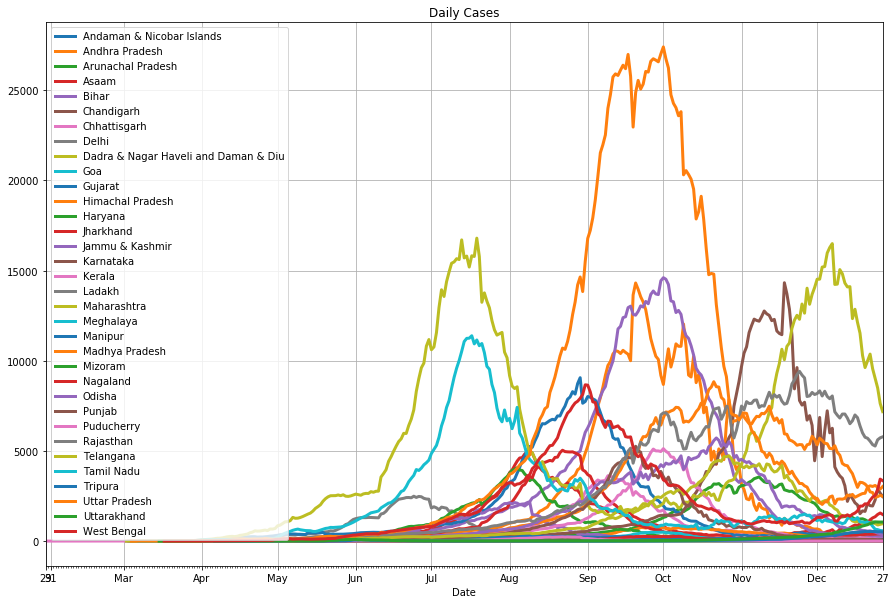

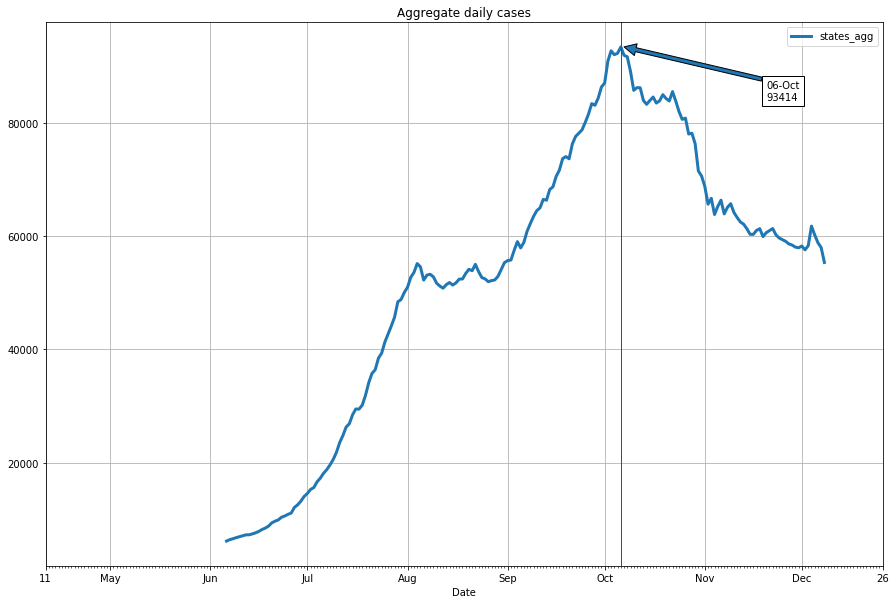

In [570]:
n_days = 200 # number of days for prediction
agg_days = n_days + 60 # number of days for plotting agg curve i.e. prediction + actual data 
states_agg = np.zeros(agg_days)
ax = None
for state in STT_INFO:
    pop_fct = STT_INFO[state]["popn"] / 1000
    
    state_df = states_df.loc[states_df['state']==state][:-1] # skip todays data. covid19 returns incomplete.
    state_df = expand(state_df)
    state_df['daily'] = state_df['total'] - state_df['total'].shift(1).fillna(0)
    test_data = np.array(state_df['daily'].rolling(7, center=True, min_periods=1).mean() / pop_fct, dtype=np.float32)

    in_data = test_data[-IP_SEQ_LEN:]
    out_data = np.array([], dtype=np.float32)
    for i in range(int(n_days / OP_SEQ_LEN)):
        ip = torch.tensor(
            in_data,
            dtype=torch.float32
        ).to(device)
        try:
            pred = model.predict(ip.view(IP_SEQ_LEN, 1, 1))
        except Exception as e:
            print(state, e)
        in_data = np.append(in_data[-IP_SEQ_LEN+OP_SEQ_LEN:], pred.cpu().numpy())
        out_data = np.append(out_data, pred.cpu().numpy())
    
    sn = STT_INFO[state]['name']
    orig_df = pd.DataFrame({
        'actual': np.array(test_data * pop_fct, dtype=np.int)
    })
    fut_df = pd.DataFrame({
        'predicted': np.array(out_data * pop_fct, dtype=np.int)
    })
    # print(fut_df.to_csv(sep='|'))
    orig_df = orig_df.append(fut_df, ignore_index=True, sort=False)
    orig_df[sn] = orig_df['actual'].fillna(0) + orig_df['predicted'].fillna(0)
    orig_df['total'] = orig_df[sn].cumsum()
    
    states_agg += orig_df[sn][-agg_days:]

    # plot state chart
    start_date = state_df['date'].iloc[0]
    orig_df['Date'] = pd.to_datetime([(start_date + dt.timedelta(days=i)).strftime("%Y-%m-%d") for i in range(len(orig_df))])
#     if orig_df[sn].max() < 10000: # or orig_df[sn].max() < 5000:
#         continue
    
    # print state, cumulative, peak
    peak = orig_df.loc[orig_df[sn].idxmax()]
    print(sn, "|", peak['Date'].strftime("%b %d"), "|", int(peak[sn]), "|", int(orig_df['total'].iloc[-1]))
    
    ax = orig_df.plot(
        x='Date',
        y=[sn],
        title='Daily Cases',
        figsize=(15,10),
        grid=True,
        ax=ax,
        lw=3
    )
    mn_l = DayLocator()
    ax.xaxis.set_minor_locator(mn_l)
    mj_l = AutoDateLocator()
    mj_f = ConciseDateFormatter(mj_l, show_offset=False)
    ax.xaxis.set_major_formatter(mj_f)

# plot aggregate chart
cum_df = pd.DataFrame({
    'states_agg': states_agg 
})
last_date = orig_df['Date'].iloc[-1].to_pydatetime()
start_date = last_date - dt.timedelta(days=agg_days)
cum_df['Date'] = pd.to_datetime([(start_date + dt.timedelta(days=i)).strftime("%Y-%m-%d") for i in range(len(cum_df))])
ax = cum_df.plot(
    x='Date',
    y=['states_agg'],
    title='Aggregate daily cases',
    figsize=(15,10),
    grid=True,
    lw=3
)
mn_l = DayLocator()
ax.xaxis.set_minor_locator(mn_l)
mj_l = AutoDateLocator()
mj_f = ConciseDateFormatter(mj_l, show_offset=False)
ax.xaxis.set_major_formatter(mj_f)

peakx = 178
peak = cum_df.iloc[peakx]
peak_desc = peak['Date'].strftime("%d-%b") + "\n" + str(int(peak['states_agg']))
_ = ax.annotate(
    peak_desc, 
    xy=(peak['Date'] + dt.timedelta(days=1), peak['states_agg']),
    xytext=(peak['Date'] + dt.timedelta(days=45), peak['states_agg'] * .9),
    arrowprops={},
    bbox={'facecolor':'white'}
)

_ = ax.axvline(x=peak['Date'], linewidth=1, color='r')